This notebook will get a take a protein family of choice from UniProt, download the sequences with annotations such as domains, PDB codes and taxonomy and then cluster by similarity using mmSEQs. 

The sequence space will be plotted and the most representative sequences will be taken from across the sequence space 

Finally the selected sequences will be analysed for solubility and expressebility in e coli 

Eventually this will be combined with automated analysis of the proteins in the lab to train a reinforcement learning network 

First you will need to go to uniprot, search for the interpro or pfam ID you are interested in. We will download 2 files, a Fasta file and a TSV file
for the fasta file just download the default option. for TSV follow below.
Select download, format: TSV and select the annotations you are interested in. I generally add taxnomic lineage, PDB, and domain [FT], ensure you also. 

Instead of using the API we can just download the TSV and move it to the directory you are running this notebook from. Then we will use mmseqs to clean the data create an all by all comparison, you will need to install mmseqs2 first. https://github.com/soedinglab/mmseqs2/wiki

In [1]:
# remove sequences with greater than 0.8 sequence identity
!mmseqs easy-cluster GH18_input.fasta clusterRes tmp --min-seq-id 0.8 #clusters sequences with 80% similarity

easy-cluster GH18_input.fasta clusterRes tmp --min-seq-id 0.8 

MMseqs Version:                     	15-6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask residues probability        

After cleaning the dataset we need to do an all by all comparison to cluster the sequences by similarity 

In [2]:
# perform all by all search on cleaned sequences
!mmseqs easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

all_by_all.tsv exists and will be overwritten
easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

MMseqs Version:                        	15-6f452
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias                     	1
Max reject                             	2147483647
Max accept                             	2147483647
Include identical seq. id. 

Now we will use John's Cluster tools package to analyse the results of the all by all search

In [3]:
#first import the modules we need

from ClusterTools.cluster_stream import cluster_stream
from ClusterTools.cluster_progression import cluster_progression
#from ClusterTools.circle_plot import PlotCirclesBox2D
from ClusterTools.cluster_size_table import MakeTable
from ClusterTools.cluster_consensus import ParseClusters
import sys
sys.path.append("./ClusterTools/")  # replace with the actual path
import pandas as pd
import re
import os
import zipfile
from pathlib import Path



The code below analyses how the cluster sizes vary by bitscore cutoff, other scoring metrics can be used by changing the score setting to a different column in the all_by_all.tsv file

---cutoff: 100
1 clusters with 12167 sequences
349 single nodes added
0 unconnected nodes added
---cutoff: 200
1 clusters with 11004 sequences
1512 single nodes added
0 unconnected nodes added
---cutoff: 300
6 clusters with 9797 sequences
2719 single nodes added
0 unconnected nodes added
---cutoff: 400
8 clusters with 3071 sequences
9445 single nodes added
0 unconnected nodes added
---cutoff: 500
3 clusters with 602 sequences
11914 single nodes added
0 unconnected nodes added
---cutoff: 600
1 clusters with 2 sequences
12514 single nodes added
0 unconnected nodes added
---cutoff: 700
1 clusters with 2 sequences
12514 single nodes added
0 unconnected nodes added
3579753 
27.50s

['cluster_400.csv', 'cluster_600.csv', 'cluster_200.csv', 'cluster_700.csv', 'cluster_500.csv', 'cluster_100.csv', 'cluster_300.csv']


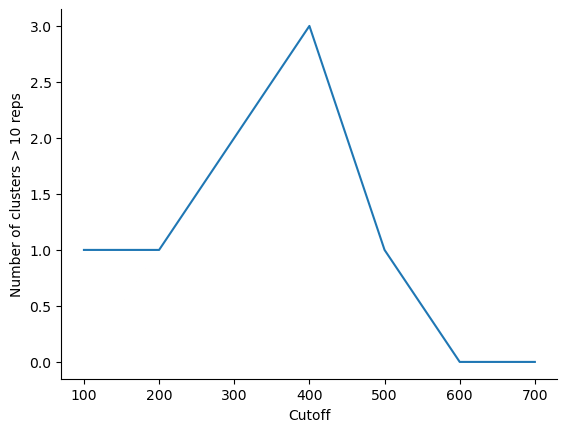

In [4]:
cluster_stream('all_by_all.tsv',cutoffs=[100,200,300,400,500,600,700], score = 3, directory='cluster_stream_res')
cluster_progression('cluster_stream_res', filter = 10) #creates the plot

the next function creates a table with the cluster IDs and the numbers of members. list files containing uniprot IDs of interest can be added as additional arguments to locate which cluster these proteins are in.

In [5]:
clusters = MakeTable('cluster_stream_res/cluster_400.csv', )
print(clusters)
clusters.to_csv('cluster_size_table.csv', index=False)

      cluster  rep_count
1           1       2468
0           0        443
2           2        149
7           7          3
3           3          2
...       ...        ...
3155     3155          1
3156     3156          1
3157     3157          1
3158     3158          1
9452     9452          1

[9453 rows x 2 columns]


The next function, ParseClusters will create a zip file containing an Hmm and an alginment file for each cluster with the most representative sequence at the top

In [8]:
def clusters_to_string_list(clusters):
    # Filter clusters with at least 2 members
    filtered_clusters = clusters[clusters['rep_count'] >= 2]  # Assuming 'rep_count' contains the member count
    return filtered_clusters['cluster'].astype(str).tolist()

cluster_list = clusters_to_string_list(clusters)
print(cluster_list)

#This function will parse the clusters and write the most representative sequences to a file
ParseClusters(cluster_file='cluster_stream_res/cluster_400.csv', fasta_file= 'GH18_input.fasta',target_clusters=cluster_list,zip_path='consensus_cutoff400.zip', id_index= 1)
print(f'Clusters collected: {clusters}') #debugging

# unzip the consensus to seperate folder
#import zipfile
#with zipfile.ZipFile('consensus_cutoff500.zip', 'r') as zip_ref:
    #zip_ref.extractall('consensus_cutoff500')

['0', '2', '1', '4', '3', '5']


IndexError: list index out of range

The below cell takes clusters of varying bit score trhesholds from JOhn's SSN workflow and compiles representatives into an 'allcluster.fasta' master file. This can be used as the basis of a phylogeny or for experimental anlaysis of the sequnence space

In [7]:


start_cluster = 100
end_cluster = 700
step = 100
cutoffs = range(start_cluster, end_cluster, step)


cluster_stream('all_by_all.tsv',cutoffs=(cutoffs), score = 3, directory='cluster_stream_res')

directory_path = 'cluster_stream_res/'
#create hmms and representative alignments for each cluster at each cutoff
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    clusters = MakeTable(file_path, ) 
    cluster_list = clusters_to_string_list(clusters)
    ParseClusters(cluster_file=file_path, fasta_file= 'input_clean.fasta',target_clusters=cluster_list,zip_path=f'{filename}_consensus.zip', id_index= 1)
    print(f'Clusters collected: {clusters}') #debugging


#extract the fasta file containing the top hits at each cutoff and combine in allcluster.fasta output file 
# Paths
output_directory = './extracted_fasta_files'
combined_fasta_path = 'allcluster.fasta'

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Step 1: Extract and rename each fasta file
for filename in os.listdir():
    if filename.endswith('.zip'):
        # Extract the number from the zip filename, e.g., '100' from 'cluster_100.csv_consensus.zip'
        cluster_number = filename.split('_')[1].split('.')[0]
        print(cluster_number)
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            for zip_info in zip_ref.infolist():
                if zip_info.filename == 'cluster_top_hits.fasta':
                    # Save each extracted fasta file with the cluster number in its filename
                    extracted_fasta_path = os.path.join(output_directory, f'cluster_{cluster_number}_top_hits.fasta')
                    with zip_ref.open(zip_info) as fasta_file, open(extracted_fasta_path, 'wb') as out_fasta:
                        out_fasta.write(fasta_file.read())
                    print(f"Extracted {extracted_fasta_path}")


with open(combined_fasta_path, 'w') as combined_fasta:
    # Loop through each .fasta file in the output directory
    for fasta_file in Path(output_directory).glob('*.fasta'):
        with open(fasta_file, 'r') as f:
            combined_fasta.write(f.read())  # Write each file's content to `allcluster.fasta`

 

---cutoff: 100
1 clusters with 12167 sequences
349 single nodes added
0 unconnected nodes added
---cutoff: 200
1 clusters with 11004 sequences
1512 single nodes added
0 unconnected nodes added
---cutoff: 300
6 clusters with 9797 sequences
2719 single nodes added
0 unconnected nodes added
---cutoff: 400
8 clusters with 3071 sequences
9445 single nodes added
0 unconnected nodes added
---cutoff: 500
3 clusters with 602 sequences
11914 single nodes added
0 unconnected nodes added
---cutoff: 600
1 clusters with 2 sequences
12514 single nodes added
0 unconnected nodes added
3579753 
21.51s


Clusters collected:       cluster  rep_count
1           1       2468
0           0        443
2           2        149
7           7          3
3           3          2
...       ...        ...
3155     3155          1
3156     3156          1
3157     3157          1
3158     3158          1
9452     9452          1

[9453 rows x 2 columns]
Clusters collected:        cluster  rep_count
0            0  